In [1]:
import pandas as pd
import numpy as np
from functools import reduce 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
plotly.offline.init_notebook_mode()
import cufflinks

import networkx as nx
import geopandas as geop

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

import h2o
from h2o.automl import H2OAutoML

plt.style.use('ggplot')
#from pandas_profiling import ProfileReport

# Incidente viales

El Centro de Comando, Control, Cómputo, Comunicaciones y Contacto Ciudadano de la CDMX (C5), es la dependencia del Gobierno de la Ciudad de México encargada de captar información integral para la toma de decisiones en materia de seguridad pública, urgencias médicas, medio ambiente, protección civil, movilidad y servicios a la comunidad en la capital del país a través del video monitoreo, de la captación de llamadas telefónicas y de aplicaciones informáticas de inteligencia, enfocadas a mejorar la calidad de vida de las y los capitalinos. Cada incidente registrado genera un folio único identificador, excepto las llamadas no procedentes o “falsas” (bromas, niños jugando, etc.) que se reciben por distintos medios.  Mientras un folio está abierto; es decir, mientras el registro está siendo atendido, éste no se carga en la base de datos interna, una vez que el folio ha sido cerrado éste se refleja en el sistema y es posible visibilizarlo internamente con un día de vencimiento, pues se realiza una recarga diaria (por esta razón las fechas de inicio y cierre de folio no necesariamente coinciden).

## Cuantos accidentes por colonia o delegacion habra

In [2]:
df_all = pd.read_csv('../Data/incidentes-viales-c5.csv')
df_all['fecha_creacion'] = pd.to_datetime(df_all['fecha_creacion'])
df_all['fecha_cierre'] = pd.to_datetime(df_all['fecha_cierre'])

print(df_all.shape)
df_all.head()


(1397992, 18)


folio fecha_creacion hora_creacion dia_semana  \
0  GA/160123/05714     2016-01-23      22:35:04     Sábado   
1  AO/160123/05826     2016-01-23      22:50:49     Sábado   
2  C4/160124/02187     2016-01-24      09:40:11    Domingo   
3  C4/160124/05723     2016-01-24      22:40:57    Domingo   
4  C4/160124/01334     2016-01-24      04:25:15    Domingo   

                                       codigo_cierre fecha_cierre  año_cierre  \
0  (A) La unidad de atención a emergencias fue de...   2016-01-24        2016   
1  (A) La unidad de atención a emergencias fue de...   2016-01-24        2016   
2  (N) La unidad de atención a emergencias fue de...   2016-01-24        2016   
3  (N) La unidad de atención a emergencias fue de...   2016-01-24        2016   
4  (A) La unidad de atención a emergencias fue de...   2016-01-24        2016   

  mes_cierre hora_cierre    delegacion_inicio  \
0      Enero    00:21:08  VENUSTIANO CARRANZA   
1      Enero    04:40:37           CUAJIMALPA   
2      Enero    11:13:03              TLALPAN   
3      Enero    22:55:51  MAGDALENA CONTRERAS   
4      Enero    05:03:59       MIGUEL HIDALGO   

                      incidente_c4    latitud   longitud  clas_con_f_alarma  \
0  accidente-choque sin lesionados  19.422113 -99.084643         EMERGENCIA   
1  accidente-choque con lesionados  19.358320 -99.297641  URGENCIAS MEDICAS   
2  accidente-choque sin lesionados  19.217070 -99.219070         EMERGENCIA   
3  accidente-choque sin lesionados  19.320580 -99.241010         EMERGENCIA   
4  accidente-choque sin lesionados  19.452900 -99.215870         EMERGENCIA   

       tipo_entrada    delegacion_cierre                  geopoint  mes  
0  BOTÓN DE AUXILIO  VENUSTIANO CARRANZA      19.422113,-99.084643    1  
1  BOTÓN DE AUXILIO           CUAJIMALPA       19.35832,-99.297641    1  
2   LLAMADA DEL 066              TLALPAN     19.21707,-99.21907008    1  
3   LLAMADA DEL 066  MAGDALENA CONTRERAS  19.32057999,-99.24100992    1  
4   LLAMADA DEL 066       MIGUEL HIDALGO  19.45289997,-99.21587004    1

In [3]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397992 entries, 0 to 1397991
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   folio              1397992 non-null  object        
 1   fecha_creacion     1397992 non-null  datetime64[ns]
 2   hora_creacion      1397992 non-null  object        
 3   dia_semana         1397992 non-null  object        
 4   codigo_cierre      1397992 non-null  object        
 5   fecha_cierre       1397992 non-null  datetime64[ns]
 6   año_cierre         1397992 non-null  int64         
 7   mes_cierre         1397992 non-null  object        
 8   hora_cierre        1397992 non-null  object        
 9   delegacion_inicio  1397834 non-null  object        
 10  incidente_c4       1397992 non-null  object        
 11  latitud            1397549 non-null  float64       
 12  longitud           1397557 non-null  float64       
 13  clas_con_f_alarma  1397992 

Comencemos filtrando la data que no es necesaria como casos de llamadas duplicada.

In [4]:
df_all['codigo_de_cierre'] = df_all.codigo_cierre.str[:3].str[1]

<AxesSubplot:>

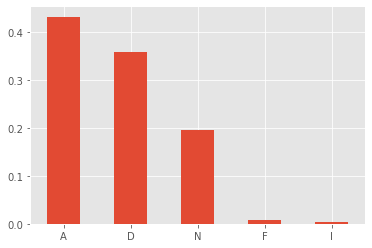

In [5]:
df_all.codigo_de_cierre.value_counts(normalize=True).plot.bar(rot=0)

### Filtro de solo quedarnos con las llamadas Afirmativas (A, I)

In [6]:
df_A = df_all[df_all.codigo_de_cierre.isin(['A','I'])]

In [7]:
print('Numero de llamadas recibidas: ',df_all.shape[0])
print('Numero de accidentes afirmados: ',df_A.shape[0])

Numero de llamadas recibidas:  1397992
Numero de accidentes afirmados:  610203


### Filtro de: **_requiere_ambulancia_**. 1 = Si requiere, 0 = No requiere.

Dividiremos los incidentes en dos grupos. El primero serán aquellos incidentes en los que SI se necesitará ambulancia (aquellos con lesionados confirmados o por confirmar) y el segundo grupo correspondera a los incidentes que NO requieran atención medica. A saber:

### Incidentes que requieren ambulancia
* accidente-choque con lesionado
* accidente-otros
* lesionado-accidente automovilístico
* lesionado-atropellado
* accidente-volcadura
* accidente-persona atrapada / desbarrancada
* cadáver-accidente automovilístico
* cadáver-atropellado
* accidente-motociclista
* accidente-choque con prensados
* accidente-vehiculo atrapado
* accidente-vehiculo desbarrancado
* accidente-ciclista
* accidente-monopatín
* sismo-choque con lesionados
* accidente-vehículo atrapado-varado
* accidente-ferroviario
* sismo-persona atropellada
* detención ciudadana-atropellado
* detención ciudadana-accidente automovilístico
* sismo-choque con prensados

### Incidentes que **NO** requieren ambulancia
* accidente-choque sin lesionado
* sismo-choque sin lesionados

In [8]:
sin_ambulancia = ['accidente-choque sin lesionados','sismo-choque sin lesionados']
df_A['requiere_ambulancia'] = np.where(df_A['incidente_c4'].isin(sin_ambulancia),0,1)

Text(0, 0.5, '%')

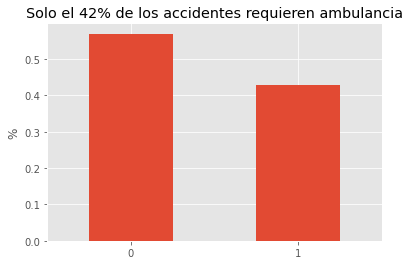

In [9]:
df_A.requiere_ambulancia.value_counts(normalize=True).plot.bar(rot=0, title="Solo el 42% de los accidentes requieren ambulancia")
plt.ylabel("%")

In [10]:
# Filtro por accidentes que necesitan ambulancias
df_A = df_A[df_A['requiere_ambulancia'] == 1]

In [11]:
df_A.dropna(inplace=True)

In [12]:
dia_dict_2 = {'Lunes':1,'Martes':2,'Miércoles':3,'Jueves':4,'Viernes':5,'Sábado':6,'Domingo':7}
dia_dict_1 = {1:'Lunes',2:'Martes',3:'Miércoles',4:'Jueves',5:'Viernes',6:'Sábado',7:'Domingo'}

# Modelo all data

In [13]:
df_all_data = pd.DataFrame(df_A.groupby(['fecha_cierre','delegacion_cierre']).size(),columns=['num_accidentes'])
df_all_data.reset_index(inplace=True)
df_all_data

fecha_cierre    delegacion_cierre  num_accidentes
0       2014-01-01       ALVARO OBREGON               8
1       2014-01-01         AZCAPOTZALCO               4
2       2014-01-01        BENITO JUAREZ               6
3       2014-01-01             COYOACAN               5
4       2014-01-01           CUAUHTEMOC              11
...            ...                  ...             ...
37148   2020-12-11       MIGUEL HIDALGO               5
37149   2020-12-11              TLAHUAC               4
37150   2020-12-11              TLALPAN               4
37151   2020-12-11  VENUSTIANO CARRANZA              10
37152   2020-12-11           XOCHIMILCO               4

[37153 rows x 3 columns]

In [14]:
df_all_data = df_all_data[df_all_data.fecha_cierre >= '2016-01-01']

## Variables Shift por alcaldia

In [15]:
%%time
dict_temp = {}
for alc in df_all_data.delegacion_cierre.unique():
    df_temp_1 = df_all_data[df_all_data.delegacion_cierre == alc].set_index('fecha_cierre').drop('delegacion_cierre',1)
    for i in range(1,16):
        df_temp_2 = pd.DataFrame(df_temp_1.num_accidentes.shift(i).dropna())
        df_temp_2.columns = [alc+'_shift_'+str(i)]
        dict_temp[alc+'shift_'+str(i)] = df_temp_2

Wall time: 233 ms


In [16]:
dfs = [x for x in dict_temp.values()]
dfs.append(df_all_data)

In [17]:
from functools import reduce 
# Merge de DataFrames

df_merged_all = reduce(lambda  left, right: pd.merge(left,right,on='fecha_cierre',
                                            how='left'), dfs)

In [18]:
print(df_merged_all.shape)
df_merged_all.fillna(inplace=True, method='bfill')
df_merged_all.dropna(inplace=True)
print(df_merged_all.shape)

(26237, 243)
(26224, 243)


### Variables de fecha

In [19]:
month_dummie = pd.get_dummies(df_merged_all.set_index('fecha_cierre').index.month)
month_dummie.set_index(df_merged_all.set_index('fecha_cierre').index, inplace=True)
month_dummie.columns = [str(c)+'_month_dummi' for c in month_dummie.columns]

dayofweekdummie = pd.get_dummies(df_merged_all.set_index('fecha_cierre').index.dayofweek)
dayofweekdummie.set_index(df_merged_all.set_index('fecha_cierre').index,inplace=True)
dayofweekdummie.columns = [str(c)+'_dayofweek_dummi' for c in dayofweekdummie.columns]

delegacion_cierre_dummie = pd.get_dummies(df_merged_all.set_index('fecha_cierre').delegacion_cierre)
delegacion_cierre_dummie.set_index(df_merged_all.set_index('fecha_cierre').index,inplace=True)
delegacion_cierre_dummie.columns = ['alcaldia_'+str(c) for c in delegacion_cierre_dummie.columns]

df_merged_1_all = pd.concat([df_merged_all.set_index('fecha_cierre'),month_dummie,dayofweekdummie, delegacion_cierre_dummie],1)
df_merged_1_all.head()

ALVARO OBREGON_shift_1  ALVARO OBREGON_shift_2  \
fecha_cierre                                                   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   

              ALVARO OBREGON_shift_3  ALVARO OBREGON_shift_4  \
fecha_cierre                                                   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   

              ALVARO OBREGON_shift_5  ALVARO OBREGON_shift_6  \
fecha_cierre                                                   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   

              ALVARO OBREGON_shift_7  ALVARO OBREGON_shift_8  \
fecha_cierre                                                   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   
2016-01-02                       5.0                     5.0   

              ALVARO OBREGON_shift_9  ALVARO OBREGON_shift_10  ...  \
fecha_cierre                                                   ...   
2016-01-02                       5.0                      5.0  ...   
2016-01-02                       5.0                      5.0  ...   
2016-01-02                       5.0                      5.0  ...   
2016-01-02                       5.0                      5.0  ...   
2016-01-02                       5.0                      5.0  ...   

              alcaldia_GUSTAVO A. MADERO  alcaldia_IZTACALCO  \
fecha_cierre                                                   
2016-01-02                             0                   0   
2016-01-02                             0                   0   
2016-01-02                             0                   0   
2016-01-02                             0                   0   
2016-01-02                             0                   0   

              alcaldia_IZTAPALAPA  alcaldia_MAGDALENA CONTRERAS  \
fecha_cierre                                                      
2016-01-02                      0                             0   
2016-01-02                      0                             0   
2016-01-02                      0                             0   
2016-01-02                      0                             0   
2016-01-02                      0                             0   

              alcaldia_MIGUEL HIDALGO  alcaldia_MILPA ALTA  alcaldia_TLAHUAC  \
fecha_cierre                                                                   
2016-01-02                          0                    0                 0   
2016-01-02                          0                    0                 0   
2016-01-02                          0                    0                 0   
2016-01-02                          0                    0                 0   
2016-01-02                          0                    0                 0   

              alcaldia_TLALPAN  alcaldia_VENUSTIANO CARRANZA  \
fecha_cierre                                                   
2016-01-02                   0                             0   
2016-01-02                   0                         

## Variables estadisticos de ventana por alcaldia

In [20]:
%%time
df_max = pd.DataFrame()
df_min = pd.DataFrame()
df_mean = pd.DataFrame()
df_median = pd.DataFrame()
df_std = pd.DataFrame()
df_cociente = pd.DataFrame()

alcaldias = df_merged_1_all.delegacion_cierre.unique()
cols_temp = [col for col in df_merged_1_all.columns if 'shift' in col] # obtencion de columnas de lags sin diff y de la moneda que queremos

#print(cols_temp)

for i in range(2, 16):
    for alcaldia in alcaldias:
        lista_lags = list(range(1, i+1))

        cols_temp_1 = [col for col in cols_temp if alcaldia in col]
        cols_temp_2 =cols_temp_1[:i]

        df_max_temp = df_merged_1_all[cols_temp_2].max(1)
        df_max_temp.columns = ['shift_max_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
        df_max = pd.concat([df_max, df_max_temp], 1)
        df_max.rename(columns={0:'shift_max_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

        df_min_temp = df_merged_1_all[cols_temp_2].min(1)
        df_min_temp.columns = ['shift_min_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
        df_min = pd.concat([df_min, df_min_temp], 1)
        df_min.rename(columns={0:'shift_min_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

        df_mean_temp = df_merged_1_all[cols_temp_2].mean(1)
        df_mean_temp.columns = ['shift_mean_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
        df_mean = pd.concat([df_mean, df_mean_temp], 1)
        df_mean.rename(columns={0:'shift_mean_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

        df_median_temp = df_merged_1_all[cols_temp_2].median(1)
        df_median_temp.columns = ['shift_median_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
        df_median = pd.concat([df_median, df_median_temp], 1)
        df_median.rename(columns={0:'shift_median_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

        df_std_temp = df_merged_1_all[cols_temp_2].std(1)
        df_std_temp.columns = ['shift_std_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
        df_std = pd.concat([df_std, df_std_temp], 1)
        df_std.rename(columns={0:'shift_std_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

        df_cociente_temp = df_merged_1_all[cols_temp_2[0]] / df_merged_1_all[cols_temp_2[-1]]
        df_cociente_temp.columns = ['shift_cociente_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
        df_cociente = pd.concat([df_cociente, df_cociente_temp], 1)
        df_cociente.rename(columns={0:'shift_cociente_'+alcaldia+'_t_'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

Wall time: 3min 27s


In [21]:
for df_temp in [df_merged_1_all,df_max,df_min,df_mean,df_median,df_std, df_cociente]:
    df_temp.index.names = ['date']
    df_temp.index = pd.to_datetime(df_temp.index)

In [22]:
df_merged_1_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26224 entries, 2016-01-02 to 2020-12-10
Columns: 277 entries, ALVARO OBREGON_shift_1 to alcaldia_XOCHIMILCO
dtypes: float64(240), int64(1), object(1), uint8(35)
memory usage: 49.5+ MB


In [25]:
[col for col in df_merged_1_all.columns if 'dele' in col]

['delegacion_cierre']

In [26]:
df_max

shift_max_ALVARO OBREGON_t_1_t2  shift_max_AZCAPOTZALCO_t_1_t2  \
date                                                                         
2016-01-02                              5.0                            4.0   
2016-01-02                              5.0                            4.0   
2016-01-02                              5.0                            4.0   
2016-01-02                              5.0                            4.0   
2016-01-02                              5.0                            4.0   
...                                     ...                            ...   
2020-12-10                              9.0                            7.0   
2020-12-10                              9.0                            7.0   
2020-12-10                              9.0                            7.0   
2020-12-10                              9.0                            7.0   
2020-12-10                              9.0                            7.0   

            shift_max_BENITO JUAREZ_t_1_t2  shift_max_COYOACAN_t_1_t2  \
date                                                                    
2016-01-02                             5.0                        5.0   
2016-01-02                             5.0                        5.0   
2016-01-02                             5.0                        5.0   
2016-01-02                             5.0                        5.0   
2016-01-02                             5.0                        5.0   
...                                    ...                        ...   
2020-12-10                             6.0                        8.0   
2020-12-10                             6.0                        8.0   
2020-12-10                             6.0                        8.0   
2020-12-10                             6.0                        8.0   
2020-12-10                             6.0                        8.0   

            shift_max_CUAJIMALPA_t_1_t2  shift_max_CUAUHTEMOC_t_1_t2  \
date                                                                   
2016-01-02                         11.0                          5.0   
2016-01-02                         11.0                          5.0   
2016-01-02                         11.0                          5.0   
2016-01-02                         11.0                          5.0   
2016-01-02                         11.0                          5.0   
...                                 ...                          ...   
2020-12-10                          4.0                         16.0   
2020-12-10                          4.0                         16.0   
2020-12-10                          4.0                         16.0   
2020-12-10                          4.0                         16.0   
2020-12-10                          4.0                         16.0   

            shift_max_GUSTAVO A. MADERO_t_1_t2  shift_max_IZTACALCO_t_1_t2  \
date                                                                         
2016-01-02                                11.0                         3.0   
2016-01-02                                11.0                         3.0   
2016-01-02                                11.0                         3.0   
2016-01-02                                11.0                         3.0   
2016-01-02                                11.0                         3.0   
...                                        ...                         ...   
2020-12-10                                 8.0                         7.0   
2020-12-10                                 8.0                         7.0   
2020-12-10                                 8.0                         7.0   
2020-12-10                                 8.0                         7.0   
2020-12-10                                 8.0                         7.0   

            shift_max_IZTAPALAPA_t_1_t2  shift_max_MIGUEL HIDALGO_t_1_t2  ...  \
date          

In [30]:
df_merged_1_all.reset_index().set_index(['date','delegacion_cierre'])

ALVARO OBREGON_shift_1  \
date       delegacion_cierre                             
2016-01-02 ALVARO OBREGON                          5.0   
           AZCAPOTZALCO                            5.0   
           BENITO JUAREZ                           5.0   
           COYOACAN                                5.0   
           CUAJIMALPA                              5.0   
...                                                ...   
2020-12-10 MIGUEL HIDALGO                          9.0   
           MILPA ALTA                              9.0   
           TLALPAN                                 9.0   
           VENUSTIANO CARRANZA                     9.0   
           XOCHIMILCO                              9.0   

                                ALVARO OBREGON_shift_2  \
date       delegacion_cierre                             
2016-01-02 ALVARO OBREGON                          5.0   
           AZCAPOTZALCO                            5.0   
           BENITO JUAREZ                           5.0   
           COYOACAN                                5.0   
           CUAJIMALPA                              5.0   
...                                                ...   
2020-12-10 MIGUEL HIDALGO                          5.0   
           MILPA ALTA                              5.0   
           TLALPAN                                 5.0   
           VENUSTIANO CARRANZA                     5.0   
           XOCHIMILCO                              5.0   

                                ALVARO OBREGON_shift_3  \
date       delegacion_cierre                             
2016-01-02 ALVARO OBREGON                          5.0   
           AZCAPOTZALCO                            5.0   
           BENITO JUAREZ                           5.0   
           COYOACAN                                5.0   
           CUAJIMALPA                              5.0   
...                                                ...   
2020-12-10 MIGUEL HIDALGO                          5.0   
           MILPA ALTA                              5.0   
           TLALPAN                                 5.0   
           VENUSTIANO CARRANZA                     5.0   
           XOCHIMILCO                              5.0   

                                ALVARO OBREGON_shift_4  \
date       delegacion_cierre                             
2016-01-02 ALVARO OBREGON                          5.0   
           AZCAPOTZALCO                            5.0   
           BENITO JUAREZ                           5.0   
           COYOACAN                                5.0   
           CUAJIMALPA                              5.0   
...                                                ...   
2020-12-10 MIGUEL HIDALGO                          4.0   
           MILPA ALTA                              4.0   
           TLALPAN                                 4.0   
           VENUSTIANO CARRANZA                     4.0   
           XOCHIMILCO                              4.0   

                                ALVARO OBREGON_shift_5  \
date       delegacion_cierre                             
2016-01-02 ALVARO OBREGON                          5.0   
           AZCAPOTZALCO                            5.0   
           BENITO JUAREZ                           5.0   
           COYOACAN                                5.0   
           CUAJIMALPA                              5.0   
...                                                ...   
2020-12-10 MIGUEL HIDALGO                          4.0   
           MILPA ALTA                              4.0   
           TLALPAN                                 4.0   
           VENUSTIANO CARRANZA                     4.0   
           XOCHIMILCO                              4.0   

                                ALVARO OBREGON_shift_6  \
date       delegacion_cierre                             
2016-01-02 ALVARO OBREGON                          5.0   
           AZCAPOTZALCO                            5.0   
           BENITO JUAREZ 

In [31]:
data_frames = [df_merged_1_all,df_max,df_min,df_mean,df_median,df_std,df_cociente]

df_merged_2_all = reduce(lambda  left, right: pd.concat([left,right],1), data_frames)

In [33]:
df_merged_2_all

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26224 entries, 2016-01-02 to 2020-12-10
Columns: 1621 entries, ALVARO OBREGON_shift_1 to shift_cociente_MILPA ALTA_t_1_t15
dtypes: float64(1584), int64(1), object(1), uint8(35)
memory usage: 318.4+ MB


## Entrenar un modelo con all data

In [34]:
df_merged_2_all.shape[0] * 0.8

20979.2

In [42]:
nrows_80 = int(df_merged_2_all.shape[0] * 0.8)
print('Partición de datos, 80% train, 20% test')
train = df_merged_2_all[:nrows_80]
test = df_merged_2_all[nrows_80:]
y_train, y_test = train['num_accidentes'], test['num_accidentes']

print('entrenamiento modelo')
x_cols = [col for col in df_merged_2_all.columns if col not in ['num_accidentes','delegacion_cierre']]

print(train.shape)

Partición de datos, 80% train, 20% test
entrenamiento modelo
(20979, 1621)


In [44]:
train.shape, test.shape

((20979, 1621), (5245, 1621))

In [37]:
parameters_1 = {'alpha':[0.0001,0.0003,
                         0.001,0.003,0.01,
                         0.03,0.1,0.3,0.7,1,3,
                         7,20,50,100,
                         200,300,400,500,1000
                        ]}
parameters_2 = {'n_neighbors':np.arange(2,240,10)}

lr = LinearRegression()
lr.fit(train[x_cols], y_train)

lasso = Lasso()
lasso_clf = GridSearchCV(lasso, parameters_1,cv=TimeSeriesSplit(), verbose=1, n_jobs=7)
lasso_clf.fit(train[x_cols], y_train)

ridge = Ridge()
ridge_clf = GridSearchCV(ridge, parameters_1,cv=TimeSeriesSplit(), verbose=1, n_jobs=7)
ridge_clf.fit(train[x_cols], y_train)

knn = KNeighborsRegressor()
knn_clf = GridSearchCV(knn, parameters_2, cv=TimeSeriesSplit(), verbose=1, n_jobs=7)
knn_clf.fit(train[x_cols], y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(), n_jobs=7,
             param_grid={'n_neighbors': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232])},
             verbose=1)

In [46]:
def evaluate_model(name):
    print('//'*20)
    print('modelo: ',name)
    print('//'*20)
    
    r2 = r2_score(test['num_accidentes'], test['y_pred_'+name])
    rmse = mean_squared_error(test['num_accidentes'], test['y_pred_'+name], squared=False)
    mae = mean_absolute_error(test['num_accidentes'], test['y_pred_'+name])
    mape = (np.mean(np.abs(test['num_accidentes'] - test['y_pred_'+name])/np.abs(test['num_accidentes']))*100)
    
    print('R^2 = % 1.3f' %r2)
    print('Error cuadrático medio (RMSE) = % 1.3f' %rmse)
    print('Error absoluto medio (MAE) = % 1.3f' %mae)
    print('MAPE: ',mape)
    return r2,rmse,mae,mape

In [47]:
print('Evaluación del modelo')
models = [('lr',lr), ('lasso',lasso_clf),('ridge',ridge_clf),('Knn',knn_clf)]

for name,model in models:
    
    test['y_pred_'+name] = model.predict(test[x_cols]).round()
    evaluate_model(name)
    if name in ['lasso','ridge','Knn']:
        print('best_model', model.best_estimator_)

Evaluación del modelo
////////////////////////////////////////
modelo:  lr
////////////////////////////////////////
R^2 =  0.055
Error cuadrático medio (RMSE) =  4.215
Error absoluto medio (MAE) =  3.240
MAPE:  92.80826049159896
////////////////////////////////////////
modelo:  lasso
////////////////////////////////////////
R^2 =  0.542
Error cuadrático medio (RMSE) =  2.933
Error absoluto medio (MAE) =  2.169
MAPE:  62.7621184547299
best_model Lasso(alpha=0.03)
////////////////////////////////////////
modelo:  ridge
////////////////////////////////////////
R^2 =  0.446
Error cuadrático medio (RMSE) =  3.226
Error absoluto medio (MAE) =  2.440
MAPE:  70.73866727064981
best_model Ridge(alpha=100)
////////////////////////////////////////
modelo:  Knn
////////////////////////////////////////
R^2 =  0.183
Error cuadrático medio (RMSE) =  3.920
Error absoluto medio (MAE) =  2.938
MAPE:  89.01128824588706
best_model KNeighborsRegressor(n_neighbors=2)


## Desviacion estandar sklearn, Intervalo de confianza de la prediccion

In [50]:
original_test = pd.DataFrame()
for i in range(0,len(test.y_pred_lr),7):
    test_temp = test.iloc[i:i+7][[col for col in test.columns if 'y_pred' in col]]
    test_temp_std = pd.DataFrame(test_temp.std()).T
    test_temp_std.columns = ['y_pred_std_' + name[0] for name in models]
    test_temp_std = pd.concat([test_temp_std] * 7, ignore_index=True)
    long_test_temp = len(test_temp.index)
    # Por si ya no alcanzan al final los datos
    if long_test_temp < 7:
        test_temp_std = test_temp_std.iloc[:long_test_temp]
        
    test_temp_std.index = test_temp.index
    original_test = pd.concat([original_test,test_temp_std])

test_all = pd.concat([test,original_test],1)

In [51]:
# fig,ax= plt.subplots(figsize=(20,8))
# test_all.plot(y='num_accidentes', ax=ax)
# for name in models:
#     test_all.plot(y='y_pred_'+name[0], yerr='y_pred_std_'+name[0], ax=ax)

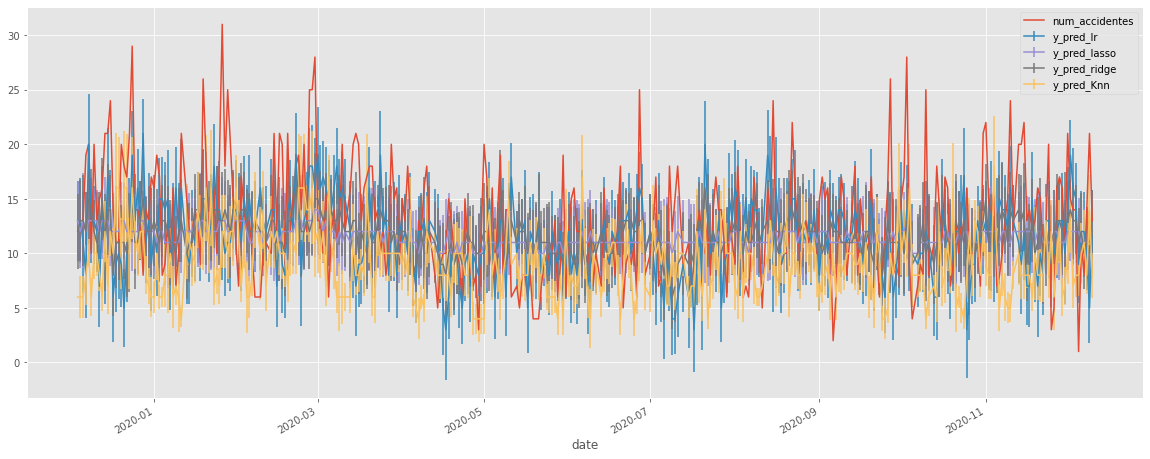

In [52]:
fig,ax= plt.subplots(figsize=(20,8))
test_all_temp = test_all[test_all.delegacion_cierre =='IZTAPALAPA']
test_all_temp.plot(y='num_accidentes', ax=ax)
for name in models:
    test_all_temp.plot(y='y_pred_'+name[0], yerr='y_pred_std_'+name[0], ax=ax)


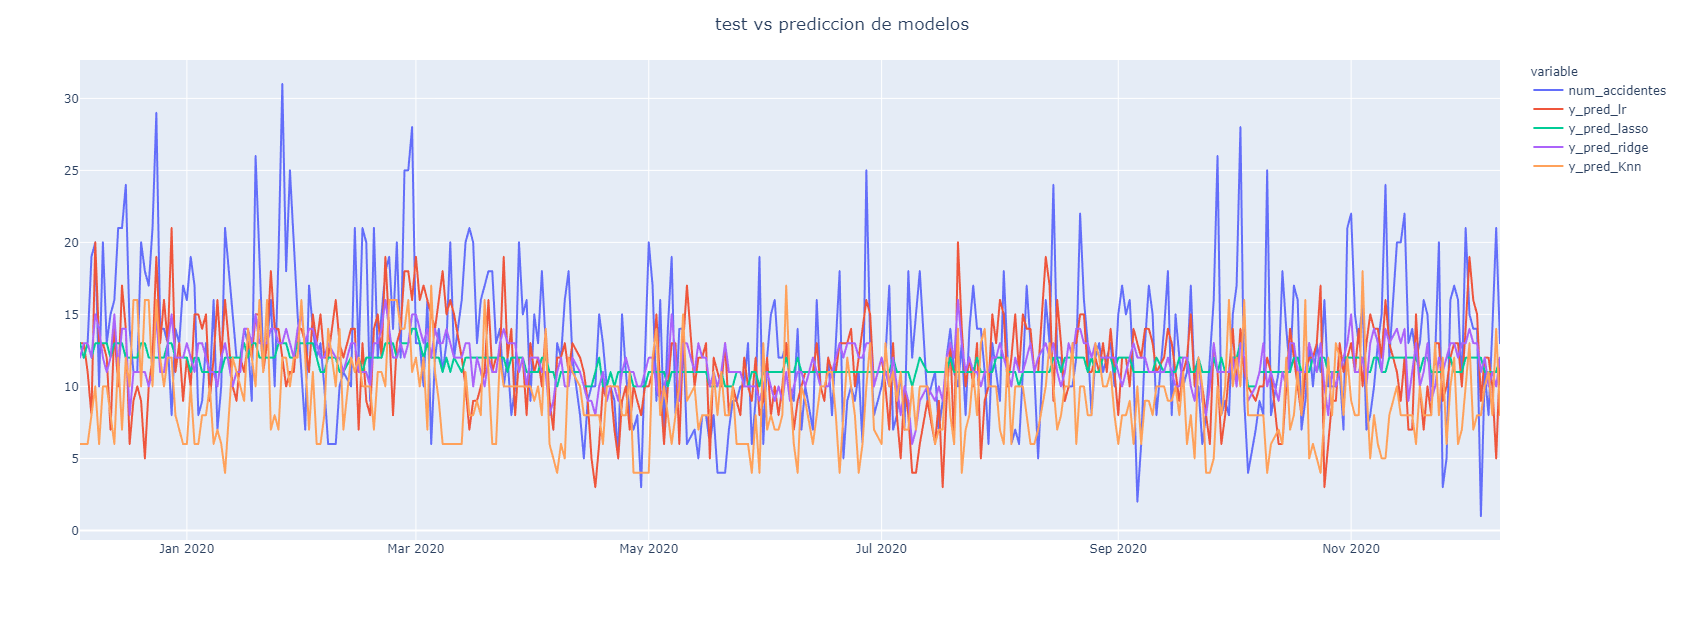

In [53]:
data_fig = test_all_temp[x_cols]
fig_eval = px.line(test_all_temp[['num_accidentes','y_pred_lr', 'y_pred_lasso', 'y_pred_ridge', 'y_pred_Knn']], x= test_all_temp.index,
                   y=['num_accidentes','y_pred_lr', 'y_pred_lasso', 'y_pred_ridge', 'y_pred_Knn'])

fig_eval.update_layout(title='test vs prediccion de modelos', title_x=0.5, xaxis_title='',
                   yaxis_title='', width=1200, height=620)
fig_eval.show()

# Probemos mas modelos

In [72]:
parameters_3 = {'n_estimators':np.linspace(2,502,3).astype(int), 'max_depth':np.arange(2,4)}

rf = RandomForestRegressor()
rf_clf = GridSearchCV(rf, parameters_3,cv=TimeSeriesSplit(),verbose=5,n_jobs=7)
rf_clf.fit(train[x_cols], y_train)

gbm = GradientBoostingRegressor()
gbm_clf = GridSearchCV(gbm, parameters_3,cv=TimeSeriesSplit(),verbose=5,n_jobs=7)
gbm_clf.fit(train[x_cols], y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=7)]: Done  24 out of  30 | elapsed:  5.2min remaining:  1.3min
[Parallel(n_jobs=7)]: Done  30 out of  30 | elapsed:  9.8min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=7)]: Done  24 out of  30 | elapsed:  7.9min remaining:  2.0min
[Parallel(n_jobs=7)]: Done  30 out of  30 | elapsed: 14.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=GradientBoostingRegressor(), n_jobs=7,
             param_grid={'max_depth': array([2, 3]),
                         'n_estimators': array([  2, 252, 502])},
             verbose=5)

In [73]:
print('Evaluación del modelo')
models = [('rf',rf_clf), ('gbm',gbm_clf)]

for name,model in models:
    
    test['y_pred_'+name] = model.predict(test[x_cols]).round()
    evaluate_model(name)
    if name in ['rf','gbm']:
        print('best_model', model.best_estimator_)

Evaluación del modelo
////////////////////////////////////////
modelo:  rf
////////////////////////////////////////
R^2 =  0.328
Error cuadrático medio (RMSE) =  3.673
Error absoluto medio (MAE) =  3.007
MAPE:  112.62877146793168
best_model RandomForestRegressor(max_depth=3, n_estimators=502)
////////////////////////////////////////
modelo:  gbm
////////////////////////////////////////
R^2 =  0.571
Error cuadrático medio (RMSE) =  2.934
Error absoluto medio (MAE) =  2.141
MAPE:  55.24264982309042
best_model GradientBoostingRegressor(max_depth=2, n_estimators=252)


## Desviacion estandar sklearn, Intervalo de confianza de la prediccion

In [76]:
original_test = pd.DataFrame()
for i in range(0,len(test.y_pred_rf),7):
    test_temp = test.iloc[i:i+7][[col for col in test.columns if 'y_pred' in col]]
    test_temp_std = pd.DataFrame(test_temp.std()).T
    test_temp_std.columns = ['y_pred_std_' + name[0] for name in models]
    test_temp_std = pd.concat([test_temp_std] * 7, ignore_index=True)
    long_test_temp = len(test_temp.index)
    # Por si ya no alcanzan al final los datos
    if long_test_temp < 7:
        test_temp_std = test_temp_std.iloc[:long_test_temp]
        
    test_temp_std.index = test_temp.index
    original_test = pd.concat([original_test,test_temp_std])

test_all = pd.concat([test,original_test],1)

In [77]:
# fig,ax= plt.subplots(figsize=(20,8))
# test_all.plot(y='num_accidentes', ax=ax)
# for name in models:
#     test_all.plot(y='y_pred_'+name[0], yerr='y_pred_std_'+name[0], ax=ax)

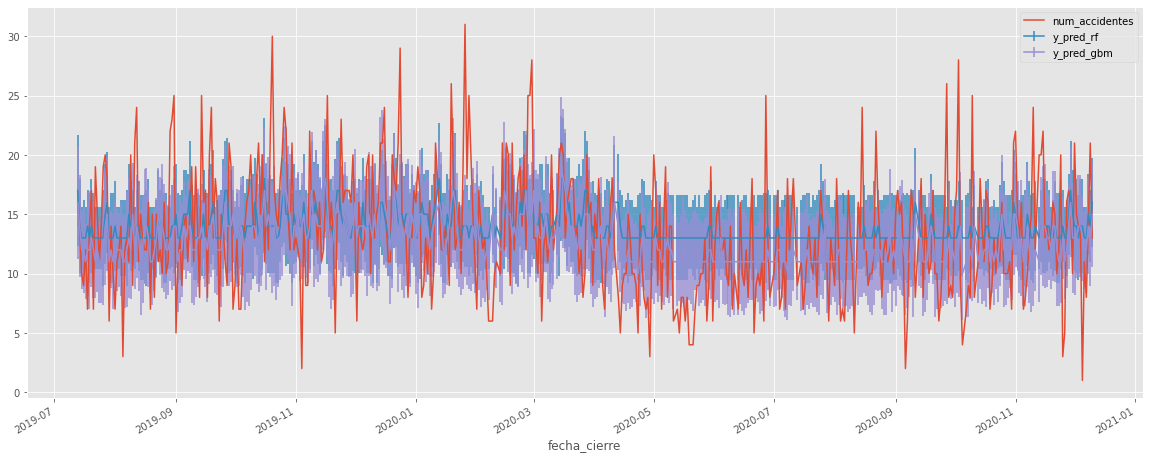

In [83]:
fig,ax= plt.subplots(figsize=(20,8))
test_all_temp=test_all[test_all.delegacion_cierre =='IZTAPALAPA']
test_all_temp.plot(y='num_accidentes', ax=ax)
for name in models:
    test_all_temp.plot(y='y_pred_'+name[0], yerr='y_pred_std_'+name[0], ax=ax)


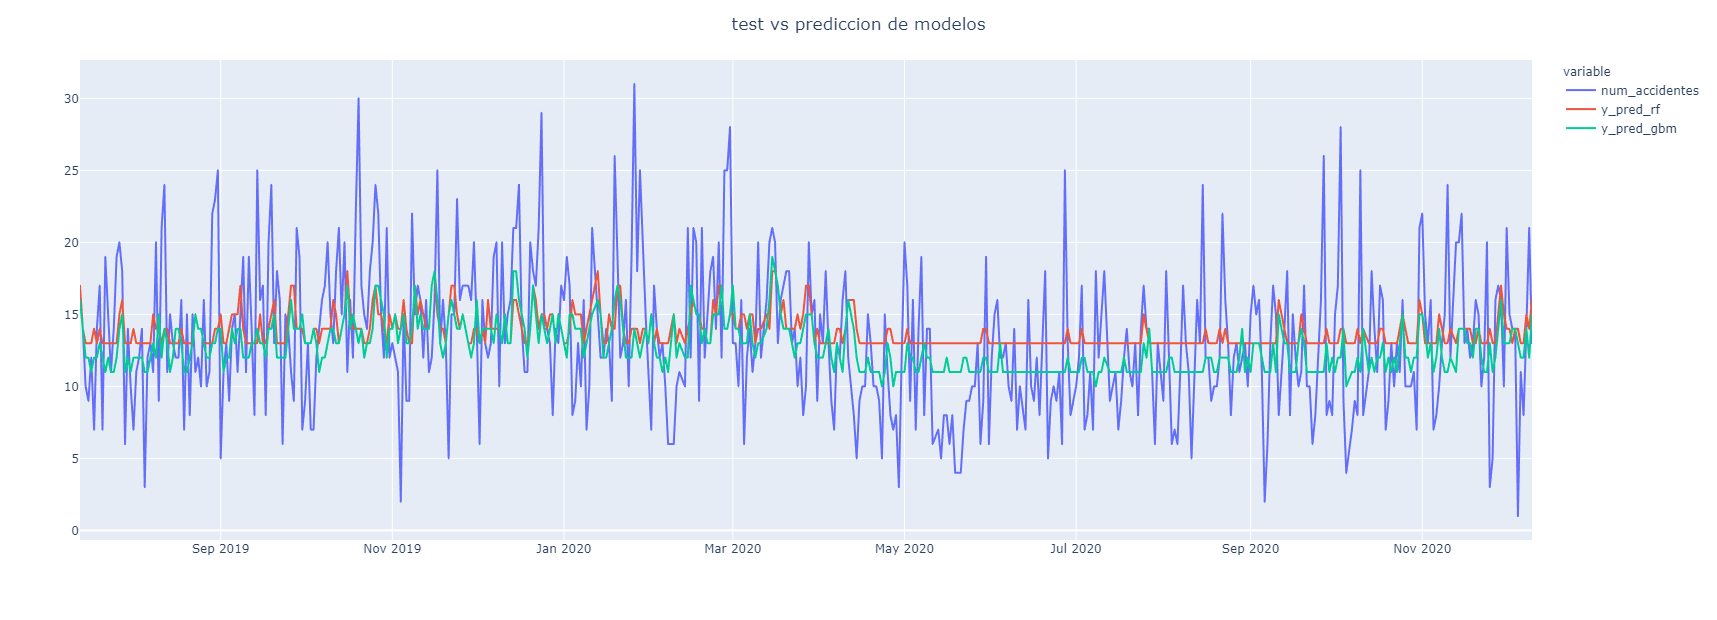

In [85]:
data_fig = test_all_temp[x_cols]
fig_eval = px.line(test_all_temp[['num_accidentes','y_pred_rf', 'y_pred_gbm', ]], x= test_all_temp.index,
                   y=['num_accidentes','y_pred_rf', 'y_pred_gbm', ])

fig_eval.update_layout(title='test vs prediccion de modelos', title_x=0.5, xaxis_title='',
                   yaxis_title='', width=1200, height=620)
fig_eval.show()

# Modelo de todas las alcaldias y obtener que mejor modelo se ajusta a cada alcaldia

Esta en RAW por que se hace el notebook muy pesado

In [ ]:
def evaluate_model_wf(name):
    print('//'*20)
    print('modelo: ',name)
    print('//'*20)
    
    r2 = r2_score(test['num_accidentes'], test['y_pred_'+name+'_wf'])
    rmse = mean_squared_error(test['num_accidentes'], test['y_pred_'+name+'_wf'], squared=False)
    mae = mean_absolute_error(test['num_accidentes'], test['y_pred_'+name+'_wf'])
    temp_test = test[test.num_accidentes !=0]
    mape = (np.mean(np.abs(temp_test['num_accidentes'] - temp_test['y_pred_'+name+'_wf'])/np.abs(temp_test['num_accidentes']))*100)
    
    print('R^2 = % 1.3f' %r2)
    print('Error cuadrático medio (RMSE) = % 1.3f' %rmse)
    print('Error absoluto medio (MAE) = % 1.3f' %mae)
    print('MAPE: ',mape)
    
    return r2,rmse,mae,mape
    
    
    

### Probemos con AutoML

In [ ]:
from h2o.automl import H2OAutoML

In [ ]:
h2o.init(nthreads=7)

In [ ]:
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

In [ ]:
aml = H2OAutoML(max_runtime_secs = 600, seed=8,)
aml.train(x=x_cols, y='num_accidentes', training_frame=train_h2o, validation_frame=test_h2o)

In [ ]:
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

In [ ]:
preds = aml.leader.predict(test_h2o)

In [ ]:
y_pred = h2o.as_list(preds)

In [ ]:
y_pred.index = test.index
y_pred = y_pred.round()
test_automl = pd.concat([test.num_accidentes,y_pred],1)

In [ ]:
original_test = pd.DataFrame()
for i in range(0,len(test_automl.predict),7):
    test_temp = test_automl.iloc[i:i+7][['predict']]
    test_temp_std = pd.DataFrame(test_temp.std()).T
    test_temp_std.columns = ['y_pred_std']
    test_temp_std = pd.concat([test_temp_std] * 7, ignore_index=True)
    long_test_temp = len(test_temp.index)
    # Por si ya no alcanzan al final los datos
    if long_test_temp < 7:
        test_temp_std = test_temp_std.iloc[:long_test_temp]
        
    test_temp_std.index = test_temp.index
    original_test = pd.concat([original_test,test_temp_std])

test_all = pd.concat([test_automl,original_test],1)

In [ ]:

print('//'*20)
print('modelo: ','AUTOML')
print('//'*20)

r2 = r2_score(test_all['num_accidentes'], test_all['predict'])
rmse = mean_squared_error(test_all['num_accidentes'], test_all['predict'], squared=False)
mae = mean_absolute_error(test_all['num_accidentes'], test_all['predict'])
mape = (np.mean(np.abs(test_all['num_accidentes'] - test_all['predict'])/np.abs(test_all['num_accidentes']))*100)

print('R^2 = % 1.3f' %r2)
print('Error cuadrático medio (RMSE) = % 1.3f' %rmse)
print('Error absoluto medio (MAE) = % 1.3f' %mae)
print('MAPE: ',mape)


In [ ]:
fig, ax= plt.subplots(figsize=(20,8))
test_all.plot(y='num_accidentes', ax=ax)
test_all.plot(y='predict', yerr='y_pred_std', ax=ax)

In [ ]:
fig_eval = px.line(test_all[['num_accidentes','predict']])

fig_eval.update_layout(title='test vs prediccion de modelos', title_x=0.5, xaxis_title='',
                   yaxis_title='', width=1200, height=620)
fig_eval.show()

In [ ]:
h2o.cluster().shutdown()